In [183]:
# Data reading 
import pandas as pd
import numpy as np
import networkx as nx

# Data visualisation
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns

# NLP 
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import collections

# Network 
from pyvis.network import Network
import community.community_louvain as cl

!pip install python_louvain

In [3]:
# Load datasets 
characters = pd.read_csv("data/characters_list.csv", sep='\t') # List of characters
script = pd.read_csv("data/Gilmore_Girls_Lines.csv", sep=',')

In [4]:
characters

,full name,name
0,A.K.,A.K.
1,Al,Al
2,Alex Lesman,Alex
3,Allen Prescott,Allen
4,Andrew,Andrew
...,...,...
150,Tristin Dugray,Tristin
151,William Danes,William
152,Young Chui,Chui
153,Zach,Zach


In [5]:
# Count lines by character
char_lines = script.groupby(['Character'], as_index=False)['Line'].count().sort_values(['Line'], ascending=False)

In [6]:
# Percent of lines said by character
char_lines['Percent'] = char_lines['Line']/char_lines['Line'].sum()

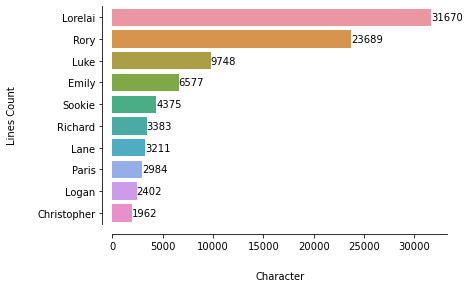

In [7]:
# Barplot of said lines 

# Set style 
sns.set_palette('Set2')

# Plot 
fig = sns.barplot(data=char_lines[:10], x="Line", y="Character")

# Customize
plt.ylabel("Lines Count", labelpad=20)
plt.xlabel("Character",labelpad=20)
sns.despine(offset=10)

for i in fig.containers:
    fig.bar_label(i,)

In [8]:
# Number of character per season
seasons_char= script.groupby(['Season'], as_index=False)['Character'].nunique().sort_values('Character', ascending=False)

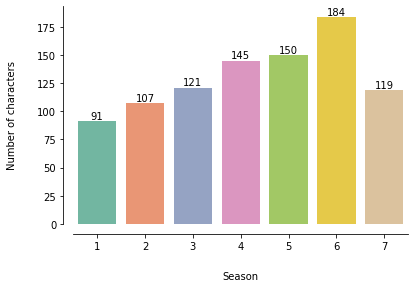

In [9]:
# Barplot of seasons characters distribution 
fig2 = sns.barplot(data=seasons_char, x="Season", y="Character")
plt.ylabel("Number of characters", labelpad=20)
plt.xlabel("Season",labelpad=20)
sns.despine(offset=10)
for i in fig2.containers:
    fig2.bar_label(i,)

In [10]:
# Number of lines per season
count_lines = script.groupby(['Season'], as_index=False)['Line'].count().sort_values('Line', ascending=True)

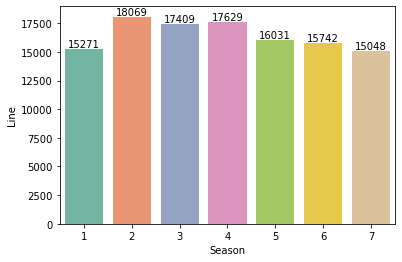

In [11]:
fig3 = sns.barplot(data=count_lines, x="Season", y="Line")
for i in fig3.containers:
    fig3.bar_label(i,)

In [12]:
# Import stopwords 
stop_words = stopwords.words('english')
stop_words.extend(["uh","oh","okay","im","dont", "know", "yeah", "thats", "youre", "well", "what", "ok", "isnt", "dont",
                  "yes", "no", "theres", "cant", "didnt", "whats"])

In [13]:
# Characters lines 
lorelai = script[script['Character'] == "Lorelai"].reset_index(drop=True)
lorelai = lorelai['Line']
rory = script[script['Character'] == "Rory"].reset_index(drop=True)
rory = rory['Line']

In [14]:
# Tokenize and clean data 
def clean_data(data):
    data = " ".join(data) # Join the text 
    data = re.sub(r'[^\w\s]', '', data) # Delete unwanted characters 
    tokens = data.split() 
    tokens = [word.lower() for word in tokens] # Lower all the letters 
    tokens = [word for word in tokens if not word in stop_words] # Ignore stopwords
    text = " ".join(tokens) # Create one joined sentence  
    return text

In [15]:
# Generate wordcloud 
def generate_wordcloud(text):
    word_cloud= WordCloud(width=1920,height=1080, background_color="white", colormap='tab20b', collocations=False).generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(word_cloud)

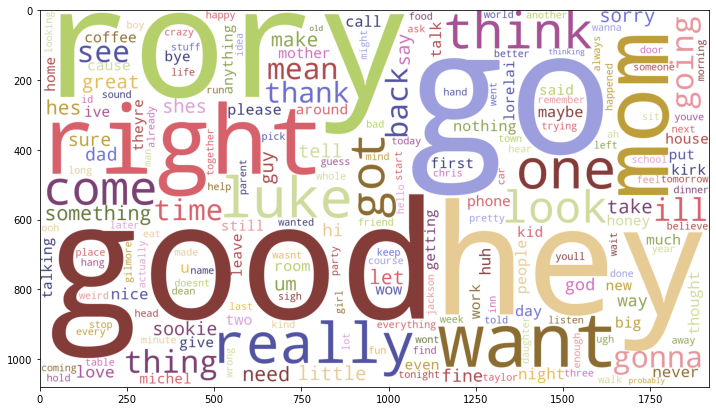

In [16]:
# Lorelai's wordcloud
lorelai_text = clean_data(lorelai)
generate_wordcloud(lorelai_text)

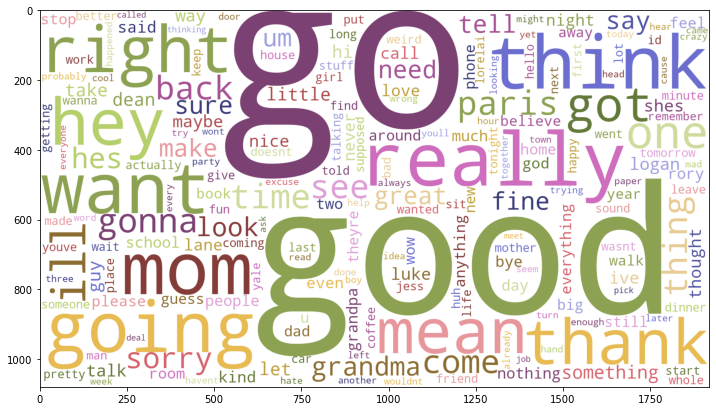

In [17]:
# Rory's wordcloud 
rory_text = clean_data(rory)
generate_wordcloud(rory_text)

In [18]:
# Create a list of numbers 
input = 23041
output = list(range(input + 1))
scenes = list(np.repeat(output, 5))

In [19]:
script['Scene'] = scenes[5:] # Add number of a scene to column 

In [20]:
char_dict = {}
for group, group_df in script.groupby(['Scene']): # Group by scenes of 5 
    
    # Get the list of characters that appear in scene, sorted alphabetically
    char_in_scene = str(group_df['Character'].sort_values().unique().tolist())[1:-1].replace("'","")

    # Add to dictionary 
    if char_in_scene in char_dict.keys():
        char_dict[char_in_scene] +=1
    else:
        char_dict[char_in_scene] = 1

# Sort the dictionary by count (second item) 
sorted_char_list = sorted(char_dict.items(), key=lambda item: item[1], reverse = True)

In [21]:
# Add to dictionary 
sorted_dict={}
for k, v in sorted_char_list:
    sorted_dict[k] = v

In [22]:
# Get the relations of 2 characters from the character's list 
relations=[]
for x in characters['name']:
    for y in characters['name']:
            if x!=y and x<y: # Alphabetically 
                relations.append(x+ ', ' + y)

In [23]:
# Add to dictionary only the elements that appear in relations list  
rel_dict = {}
for x in relations:
    if x in sorted_dict.keys():
        rel_dict[x] = sorted_dict[x]

# List sorted by count
sorted_rel = sorted(rel_dict.items(), key=lambda item: item[1],reverse = True)

In [222]:
# Create a dataframe 
final_df = pd.DataFrame(sorted_rel, columns=['Source','Count'])
final_df[['Source', 'Target']] = final_df['Source'].str.split(',', expand=True)

# Delete rows with less than 2 scenes in the show 
final_df['Count'] = final_df[final_df['Count'] > 2]['Count']
final_df = final_df.dropna()
final_df['Count'] = final_df['Count'].astype(int)

# Change columns position
final_df = final_df.loc[:,['Source','Target','Count']]

In [223]:
# Build a network 

# Edges
df = final_df
df.columns=['Source', 'Target', 'Count']
df['Source'] = df['Source'].str.replace(' ', '') # Delete accidental spaces 
df['Target'] = df['Target'].str.replace(' ', '')

In [226]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(df, 
                            source = "Source", 
                            target = "Target", 
                            edge_attr = "Count", 
                            create_using = nx.Graph())

In [227]:
# What are degrees of each character 
dict(G.degree)

{'Lorelai': 38,
 'Rory': 46,
 'Luke': 30,
 'Emily': 9,
 'Sookie': 7,
 'Logan': 8,
 'Paris': 13,
 'Lane': 14,
 'Dean': 10,
 'Jess': 10,
 'Richard': 10,
 'Michel': 5,
 'Max': 3,
 'Kirk': 8,
 'Zach': 7,
 'April': 2,
 'Jackson': 6,
 'Liz': 2,
 'Taylor': 5,
 'Doyle': 2,
 'Anna': 3,
 'Babette': 3,
 'Marty': 1,
 'Tristin': 3,
 'Chris': 3,
 'Dave': 2,
 'Nicole': 2,
 'Jimmy': 3,
 'Mitchum': 3,
 'Sherry': 2,
 'Brian': 2,
 'Alex': 1,
 'Francie': 2,
 'Kyon': 1,
 'Sophie': 1,
 'Louise': 3,
 'Madeline': 3,
 'Rachel': 3,
 'Bill': 1,
 'Joe': 1,
 'Susan': 1,
 'Carol': 1,
 'Lindsay': 1,
 'Caesar': 2,
 'Henry': 2,
 'Mia': 2,
 'Lucy': 2,
 'Lulu': 1,
 'Jamie': 2,
 'Sasha': 2,
 'Trevor': 1,
 'Clara': 2,
 'Floyd': 1,
 'Gil': 2,
 'Graham': 1,
 'Trix': 2,
 'Asher': 2,
 'Honor': 2,
 'Paul': 1,
 'Tom': 2,
 'Olivia': 1,
 'Carrie': 1,
 'Colin': 1,
 'Finn': 1,
 'Janet': 2,
 'Joey': 1,
 'Mitzi': 1,
 'Pete': 1,
 'Shira': 2,
 'Beau': 1,
 'Gypsy': 3,
 'Jacob': 1,
 'Todd': 1,
 'Officer': 1,
 'Robert': 1,
 'Andrew': 1,
 

In [277]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame(degree_dict.items(), columns=['name', 'centrality']).sort_values(['centrality'], ascending=False)

# Betweenness centrality
beetweenness_dict = nx.betweenness_centrality(G)
beetweenness_df = pd.DataFrame(beetweenness_dict.items(), columns=['name', 'centrality']).sort_values(['centrality'], ascending=False)

# Closeness centrality 
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(closeness_dict.items(), columns=['name', 'centrality']).sort_values(['centrality'], ascending=False)

# Eigenvector centrality 
eigenvector_dict = nx.eigenvector_centrality(G)
eigenvector_df = pd.DataFrame(eigenvector_dict.items(), columns=['name', 'centrality']).sort_values(['centrality'], ascending=False)


IndexError: index 2 is out of bounds for axis 0 with size 2

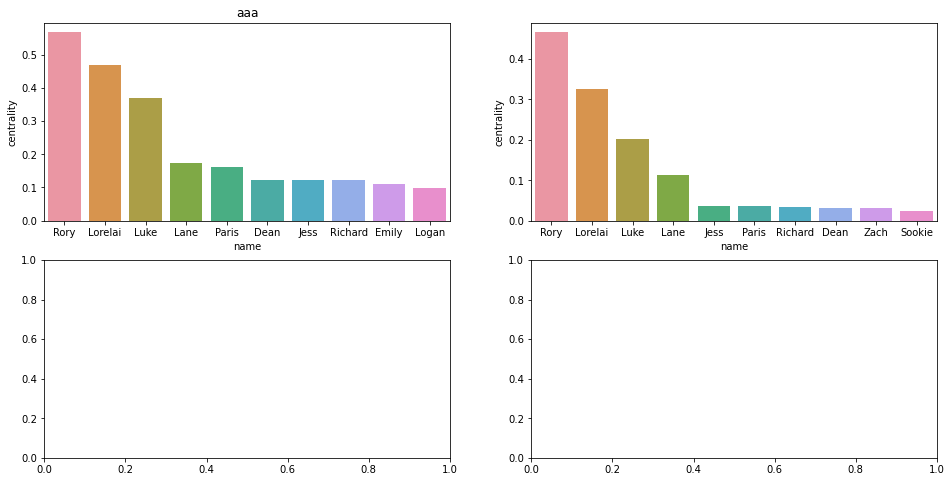

In [285]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
a= sns.barplot(ax=axes[0, 0], data=degree_df[:10], x='name', y='centrality')

sns.barplot(ax=axes[0, 1], data=beetweenness_df[:10], x='name', y='centrality')
a.set_title("aaa")


sns.barplot(ax=axes[1, 0], data=closeness_df[:10], x='name', y='centrality')
a.set_title("aaa")

sns.barplot(ax=axes[1, 1], data=eigenvector_df[:10], x='name', y='centrality')
axes[4].set_title('Title of the first chart')


In [229]:
# Create communities partition 
communities = cl.best_partition(G)

In [230]:
# Set attribute by the community  
nx.set_node_attributes(G, communities, 'group')

# Set attribute by the number of interactions 
nx.set_node_attributes(G, node_degree, 'size')

In [249]:
# Create a graph
net = Network(notebook = True, width="1200px", height="700px", bgcolor='#222222', font_color='white')
node_degree = dict(G.degree)

net.from_nx(G)

net.show("gilmore.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
